# Choosing Number of Principal Components
**TK8117 – Multivariate Data Analysis**  
**Group 5** 
**Date:** 12 Sep 2025

> Decide *k* in PCA using Explained Variance, Scree/Kaiser, Cross-Validation (reconstruction error + 1-SE).

## Agenda
* Introduction
* General approaches - Qualitative and Quantitative
* Some example data sets
* Discussion and conclusion


## General approaches - Qualitative and Quantitative

### Cumulative explained variance
* Set fixed treshold (e.g 90 %)

### Explained variance (Eigenvalues)
* Elbow row (visual or numerical)
* Kaiser rule 

<!-- ### Cross‑validation via reconstruction error (+ 1‑SE rule) (Keep?) -->

## Example data sets
### Dataset 1 -  Fox sounds

### Dataset 2 - Battery

### Dataset 3 - Iris 


## Dataset Visualization 

Dataset summary:
   Fox sounds | samples:  72 | features: 27 | classes: 9
      Battery | samples: 168 | features: 22658 | classes: 1
         Iris | samples: 150 | features:  4 | classes: 3


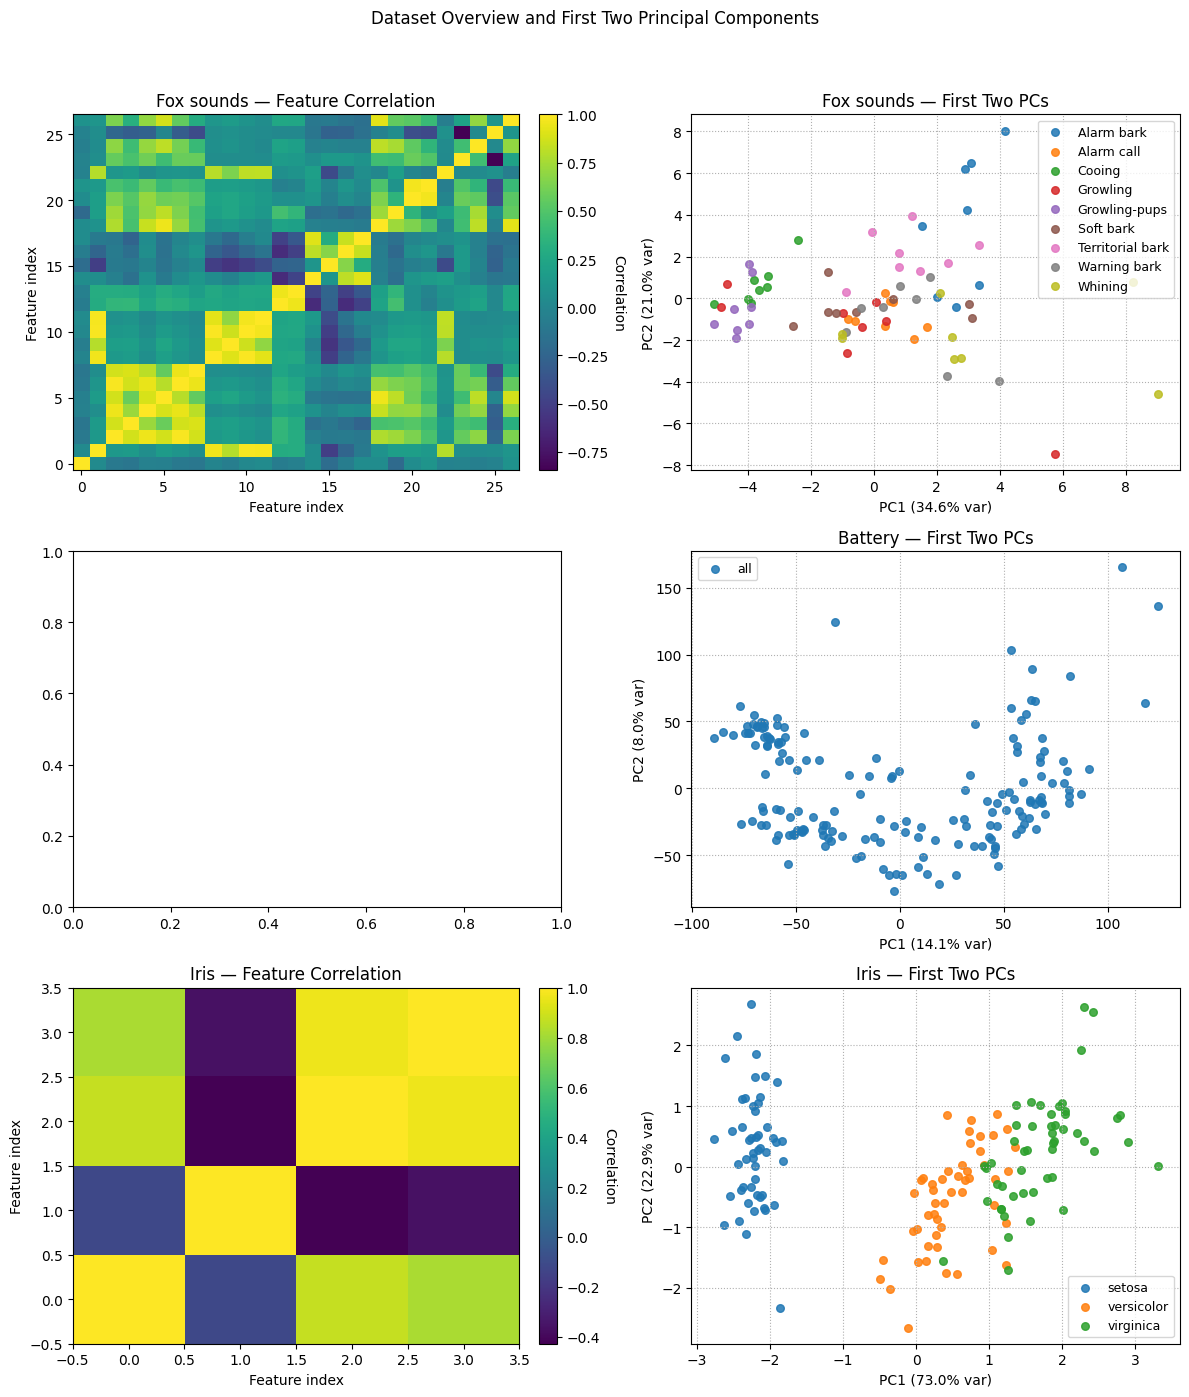

In [17]:
# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_wine, load_breast_cancer

# --- Load datasets with targets and feature names ---
def load_ds(loader):
    bunch = loader(as_frame=True)
    df = bunch.frame.copy()
    X = df.drop(columns=["target"]).to_numpy()
    y = df["target"].to_numpy()
    feature_names = [c for c in df.columns if c != "target"]
    target_names = getattr(bunch, "target_names", None)
    return X, y, feature_names, target_names

def load_csv(filename, sep=",", decimal=".", target=None, drop_columns=[]):
    df = pd.read_csv(filename, sep=sep, decimal=decimal, index_col=0)
    df = df.drop(columns=drop_columns)
    if target is None:
        y = None
        X = df.to_numpy()
        target_names = None
    else:
        y_series=df[target]
        y_cat = y_series.astype("category")
        target_names = list(y_cat.cat.categories)
        y = y_cat.cat.codes.to_numpy()
        X=df.drop(columns=[target]).to_numpy()
    feature_names = [c for c in df.columns if c != target]
    return X, y, feature_names, target_names

datasets = [
    ("Fox sounds",) + load_csv("data/subset_spectro-analysis_fox-labels.csv", sep=";", decimal=",", target="Annotation", drop_columns=["X", "sound.files"]),
    # ("Wine",) + load_ds(load_wine),
    ("Battery",) + load_csv('data/battery_data.csv', drop_columns=["EOL"]),
    # ("Breast Cancer",) + load_ds(load_breast_cancer),
    ("Iris",) + load_ds(load_iris),
]

# --- Print basic info ---
print("Dataset summary:")
for name, (X, y, feats, target_names) in zip([d[0] for d in datasets], [d[1:] for d in datasets]):
    n, p = X.shape
    classes = len(np.unique(y))
    print(f"{name:>13} | samples: {n:3d} | features: {p:2d} | classes: {classes}")

# --- Prepare plotting canvas: 3 rows (datasets) x 2 cols (info + PCs) ---
fig, axes = plt.subplots(3, 2, figsize=(12, 14))
fig.suptitle("Dataset Overview and First Two Principal Components", y=0.995)

for row, (name, X, y, feature_names, target_names) in enumerate(datasets):
    # Standardize for correlation and PCA
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)

    # --- Left: Feature correlation heatmap ---
    if X.shape[1]<50:
        corr = np.corrcoef(Xs, rowvar=False)  # p x p
        ax_hm = axes[row, 0]
        im = ax_hm.imshow(corr, aspect="auto", origin="lower")
        ax_hm.set_title(f"{name} — Feature Correlation")
        ax_hm.set_xlabel("Feature index")
        ax_hm.set_ylabel("Feature index")
        cbar = fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel("Correlation", rotation=270, labelpad=12)

    # --- Right: PC1 vs PC2 scatter (colored by class) ---
    pca = PCA(n_components=2).fit(Xs)
    Z = pca.transform(Xs)
    evr = pca.explained_variance_ratio_
    ax_sc = axes[row, 1]

    # color by class
    classes = np.unique(y)
    if len(classes) > 1:
        for i, cls in enumerate(classes):
            mask = (y == cls)
            label = target_names[cls] if target_names is not None and cls < len(target_names) else f"class {cls}"
            ax_sc.scatter(Z[mask, 0], Z[mask, 1], s=30, alpha=0.85, label=label)
    else:
        ax_sc.scatter(Z[:, 0], Z[:, 1], s=30, alpha=0.85, label="all")

    ax_sc.set_title(f"{name} — First Two PCs")
    ax_sc.set_xlabel(f"PC1 ({evr[0]*100:.1f}% var)")
    ax_sc.set_ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
    ax_sc.grid(True, linestyle=":", linewidth=0.8)
    ax_sc.legend(loc="best", fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## 1) Cumulative Explained Variance (Variance Threshold)

**Idea**  
Keep the smallest number of principal components (PCs) that explain at least a target fraction of the total variance (e.g., 90%–99%).

**How**  
1. Fit PCA on standardized data.  
2. Compute cumulative sum of `explained_variance_ratio_`.  
3. Choose the smallest $k$ such that  

$$
\sum_{i=1}^{k} \text{EVR}_i \ge \tau
$$

where $\tau$ is your target (e.g., $0.95$).

**Pros**  
- Simple, fast, model-free.  
- Easy to communicate.

**Cons**  
- Target $\tau$ is arbitrary and domain-dependent.  
- Can over-retain PCs when data are noisy or high-dimensional.

**Use when**  
You need a quick, interpretable rule of thumb or dimensionality reduction prior to downstream modeling.


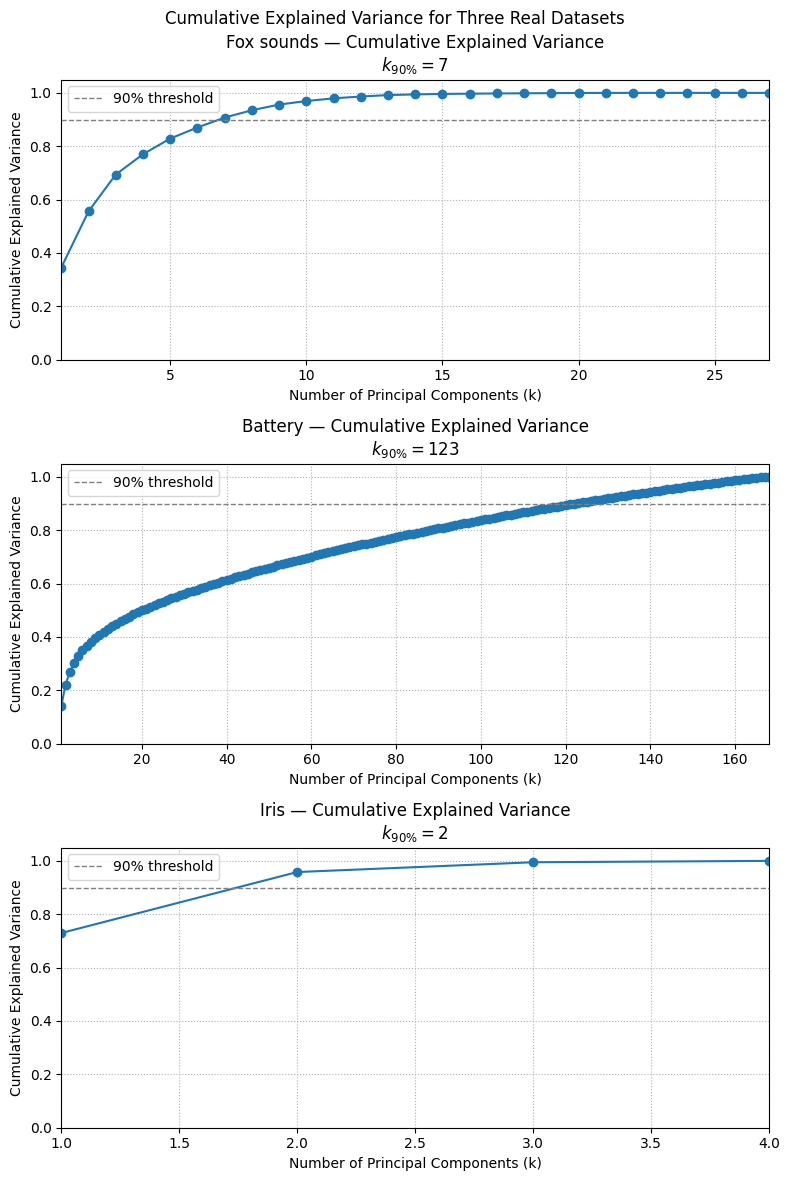

In [18]:
def cumulative_explained_variance(X, standardize=True):
    if standardize:
        X = StandardScaler().fit_transform(X)
    pca = PCA()
    pca.fit(X)
    evr = pca.explained_variance_ratio_
    return np.cumsum(evr), evr

# --- Load datasets ---
datasets = [
    ("Fox sounds", load_csv("data/subset_spectro-analysis_fox-labels.csv", sep=";", decimal=",", target="Annotation", drop_columns=["X", "sound.files"])[0]),
    #("Wine", load_wine(as_frame=True).frame.drop(columns=["target"]).to_numpy()),
    ("Battery", load_csv('data/battery_data.csv', drop_columns=["EOL"])[0]),
    # ("Breast Cancer", load_breast_cancer(as_frame=True).frame.drop(columns=["target"]).to_numpy()),
    ("Iris", load_iris(as_frame=True).frame.drop(columns=["target"]).to_numpy()),
]

tau = 0.90  # single threshold

# --- Compute cumulative EVR and k for tau ---
results = []
for name, X in datasets:
    cum, evr = cumulative_explained_variance(X, standardize=True)
    k_tau = int(np.searchsorted(cum, tau) + 1)  # one-liner for k
    results.append((name, cum, k_tau, X.shape[1]))

# --- Plot cumulative explained variance (3x1) ---
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False)

for ax, (name, cum, k_tau, nfeat) in zip(axes, results):
    xs = np.arange(1, len(cum) + 1)
    ax.plot(xs, cum, marker="o", linewidth=1.5)
    ax.axhline(tau, linestyle="--", linewidth=1.0, color="gray", label=f"{int(tau*100)}% threshold")
    ax.set_ylim(0, 1.05)
    ax.set_xlim(1, len(cum))
    ax.set_xlabel("Number of Principal Components (k)")
    ax.set_ylabel("Cumulative Explained Variance")
    ax.set_title(
        f"{name} — Cumulative Explained Variance\n"
        + r"$k_{90\%} = $" + f"{k_tau}"
    )
    ax.grid(True, linestyle=":", linewidth=0.8)
    ax.legend()

fig.suptitle("Cumulative Explained Variance for Three Real Datasets", y=0.98)
fig.tight_layout()
plt.show()


## 2) Scree Plot and the Elbow Rule

**Idea**  
Plot the variance explained by each principal component and look for the "elbow" point where the curve levels off. Keep all components up to that elbow.

**How**  
1. Fit PCA on standardized data.  
2. Plot eigenvalues or `explained_variance_ratio_` against the component index $k$.  
3. Identify the elbow where adding more components provides diminishing returns.  
   - In the code, this is done automatically with the **maximum distance method**:  
     - Draw a straight line between the first point (PC1) and the last point (PC_n).  
     - For each intermediate point, compute its perpendicular distance to this line.  
     - The component with the **largest distance** is chosen as the elbow $k_{\text{elbow}}$.

**Pros**  
- Intuitive visual diagnostic.  
- No need to choose a variance threshold beforehand.  
- Can be automated using geometric heuristics such as the maximum distance method.

**Cons**  
- Still somewhat heuristic: different methods may give slightly different elbows.  
- If the variance spectrum decays smoothly, the elbow may not be clear.

**Use when**  
You want a quick visual method to check dimensionality, often as a complement to the cumulative variance threshold.


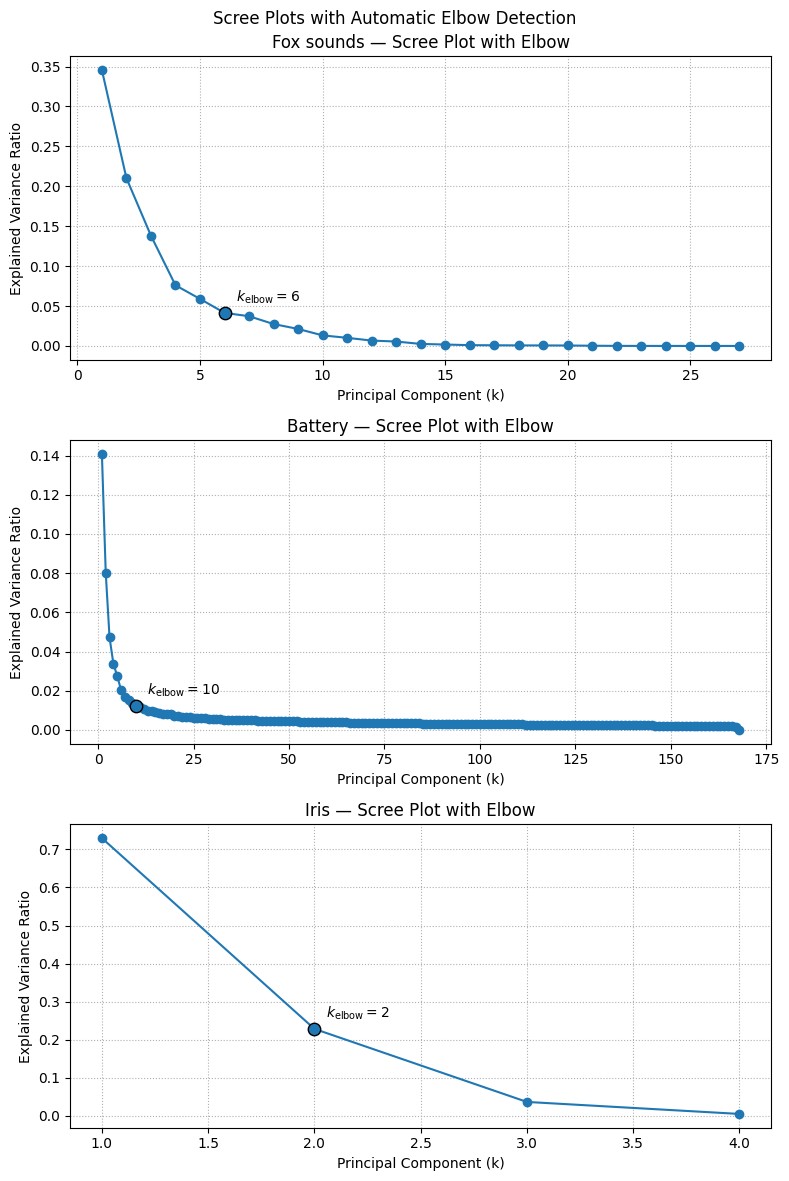

In [19]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_wine, load_breast_cancer

def explained_variance(X, standardize=True):
    if standardize:
        X = StandardScaler().fit_transform(X)
    pca = PCA()
    pca.fit(X)
    return pca.explained_variance_ratio_

def elbow_index_max_distance(y):
    """
    Heuristic elbow finder:
    - x = 1..n
    - y = sequence (e.g., explained_variance_ratio_)
    - Returns 0-based index of the point with maximum perpendicular distance
      to the line between (1, y1) and (n, yn).
    """
    n = len(y)
    x = np.arange(1, n + 1)

    # line from (x1,y1) to (xn,yn)
    x1, y1 = x[0], y[0]
    x2, y2 = x[-1], y[-1]

    # distances from each (xi, yi) to the line
    # formula for point-line distance in 2D
    num = np.abs((y2 - y1) * x - (x2 - x1) * y + x2*y1 - y2*x1)
    den = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    dist = num / (den + 1e-12)

    return int(np.argmax(dist))

# --- Load datasets ---
datasets = [
    ("Fox sounds", load_csv("data/subset_spectro-analysis_fox-labels.csv", sep=";", decimal=",", target="Annotation", drop_columns=["X", "sound.files"])[0]),
    # ("Wine", load_wine(as_frame=True).frame.drop(columns=["target"]).to_numpy()),
    ("Battery", load_csv('data/battery_data.csv', drop_columns=["EOL"])[0]),
    # ("Breast Cancer", load_breast_cancer(as_frame=True).frame.drop(columns=["target"]).to_numpy()),
    ("Iris", load_iris(as_frame=True).frame.drop(columns=["target"]).to_numpy()),
]

# --- Plot Scree Plots with elbow marker (3x1) ---
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False)

for ax, (name, X) in zip(axes, datasets):
    evr = explained_variance(X, standardize=True)
    xs = np.arange(1, len(evr) + 1)

    # elbow index (0-based), convert to k (1-based)
    ei = elbow_index_max_distance(evr)
    k_elbow = ei + 1

    ax.plot(xs, evr, marker="o", linewidth=1.5)
    ax.scatter([k_elbow], [evr[ei]], s=80, edgecolor="black", zorder=3)
    ax.annotate(rf"$k_{{\text{{elbow}}}}={k_elbow}$",
                (k_elbow, evr[ei]),
                textcoords="offset points", xytext=(8, 8))

    ax.set_xlabel("Principal Component (k)")
    ax.set_ylabel("Explained Variance Ratio")
    ax.set_title(f"{name} — Scree Plot with Elbow")
    ax.grid(True, linestyle=":", linewidth=0.8)

fig.suptitle("Scree Plots with Automatic Elbow Detection", y=0.98)
fig.tight_layout()
plt.show()


## 3) Kaiser rule

**Idea**  
Use only the principal components with eigenvalues greater than 1. When data is scaled to
unit variance, then each original variable contributes with 1 unit of variance. So a PC
with eigenvalue higher than 1 explains more than a orignal variable.

**How**  
1. Fit PCA on standardized data.  
2. Keep only the PCs with eigenvalues higher than 1

**Pros**  
- Easy to apply  
- No need to choose a variance threshold beforehand.  

**Cons**  
- Still a heuristic: Can overestimate or underestimate the number of components  



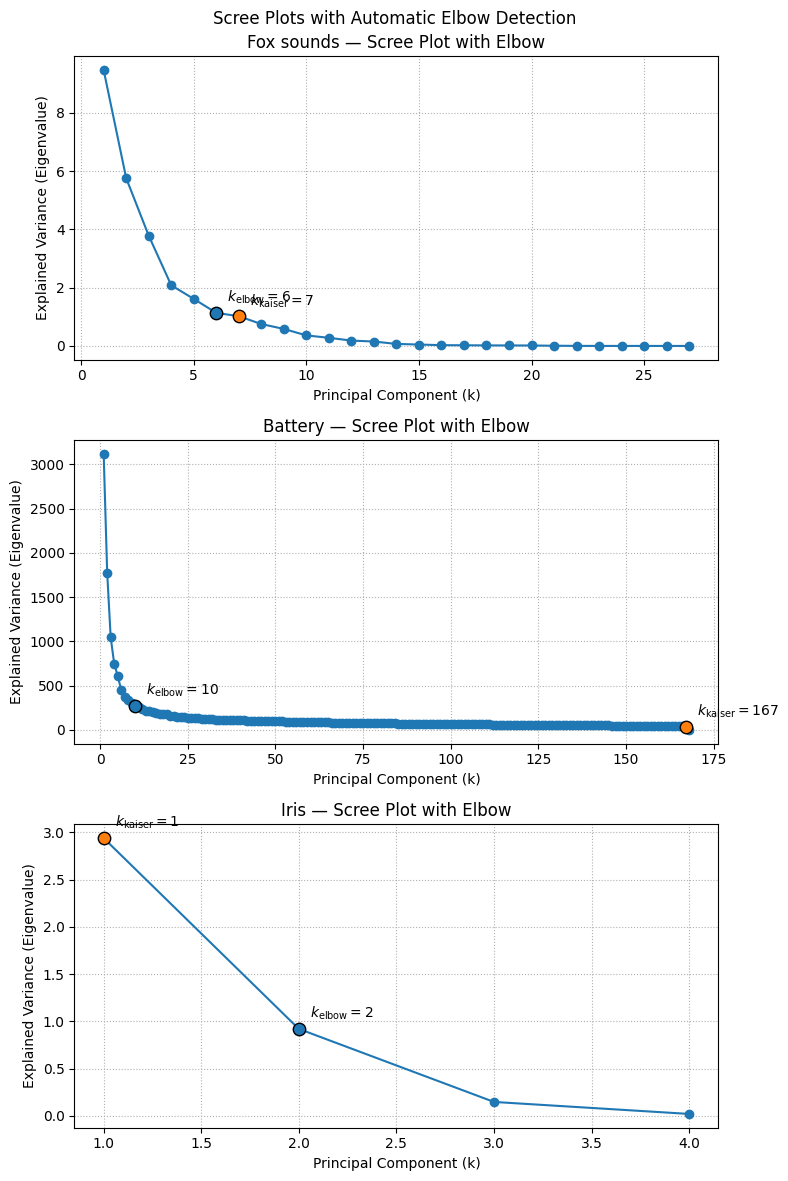

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_wine, load_breast_cancer

def explained_variance(X, standardize=True):
    if standardize:
        X = StandardScaler().fit_transform(X)
    pca = PCA()
    pca.fit(X)
    return pca.explained_variance_

def elbow_index_max_distance(y):
    """
    Heuristic elbow finder:
    - x = 1..n
    - y = sequence (e.g., explained_variance_ratio_)
    - Returns 0-based index of the point with maximum perpendicular distance
      to the line between (1, y1) and (n, yn).
    """
    n = len(y)
    x = np.arange(1, n + 1)

    # line from (x1,y1) to (xn,yn)
    x1, y1 = x[0], y[0]
    x2, y2 = x[-1], y[-1]

    # distances from each (xi, yi) to the line
    # formula for point-line distance in 2D
    num = np.abs((y2 - y1) * x - (x2 - x1) * y + x2*y1 - y2*x1)
    den = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    dist = num / (den + 1e-12)

    return int(np.argmax(dist))

# --- Load datasets ---
datasets = [
    ("Fox sounds", load_csv("data/subset_spectro-analysis_fox-labels.csv", sep=";", decimal=",", target="Annotation", drop_columns=["X", "sound.files"])[0]),
    # ("Wine", load_wine(as_frame=True).frame.drop(columns=["target"]).to_numpy()),
    ("Battery", load_csv('data/battery_data.csv', drop_columns=["EOL"])[0]),
    # ("Breast Cancer", load_breast_cancer(as_frame=True).frame.drop(columns=["target"]).to_numpy()),
    ("Iris", load_iris(as_frame=True).frame.drop(columns=["target"]).to_numpy()),
]

# --- Plot Scree Plots with elbow marker (3x1) ---
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False)

for ax, (name, X) in zip(axes, datasets):
    evr = explained_variance(X, standardize=True)
    xs = np.arange(1, len(evr) + 1)

    # elbow index (0-based), convert to k (1-based)
    ei = elbow_index_max_distance(evr)
    k_elbow = ei + 1
    k_kaiser = int(np.sum(evr > 1.0))

    ax.plot(xs, evr, marker="o", linewidth=1.5)
    ax.scatter([k_elbow], [evr[ei]], s=80, edgecolor="black", zorder=3)
    ax.scatter([k_kaiser], [evr[k_kaiser-1]], s=80, edgecolor="black", zorder=3)
    ax.annotate(rf"$k_{{\text{{elbow}}}}={k_elbow}$",
                (k_elbow, evr[ei]),
                textcoords="offset points", xytext=(8, 8))
    ax.annotate(rf"$k_{{\text{{kaiser}}}}={k_kaiser}$",
                (k_kaiser, evr[k_kaiser-1]),
                textcoords="offset points", xytext=(8, 8))

    ax.set_xlabel("Principal Component (k)")
    ax.set_ylabel("Explained Variance (Eigenvalue)")
    ax.set_title(f"{name} — Scree Plot with Elbow")
    ax.grid(True, linestyle=":", linewidth=0.8)

fig.suptitle("Scree Plots with Automatic Elbow Detection", y=0.98)
fig.tight_layout()
plt.show()

## 3) Cross-Validation for Reconstruction or Task Performance

**Idea**  
Choose the number of components $k$ that optimizes performance on held-out data.  
Two common approaches:  
- **Unsupervised**: minimize reconstruction error on validation data.  
- **Supervised**: maximize predictive accuracy for a downstream task using PCs as features.

**How**  
1. Split data into training and validation sets (or use $k$-fold cross-validation).  
2. For each candidate $k$:  
   - Fit PCA on the training set.  
   - Project validation data onto the first $k$ PCs.  
   - Reconstruct validation data (unsupervised) or train/evaluate a predictive model (supervised).  
3. Select the $k$ that minimizes validation error (unsupervised) or maximizes validation accuracy (supervised).

**Pros**  
- Objective and data-driven.  
- Directly optimizes the metric you care about.  
- Works for both unsupervised and supervised settings.

**Cons**  
- More computationally expensive than simple rules (variance threshold or scree plot).  
- Requires careful setup to avoid data leakage (PCA must be fit only on training folds).  
- May yield different $k$ depending on the metric used.

**Use when**  
You want a principled way to select $k$ based on generalization performance, especially if PCA is a preprocessing step for a predictive task.


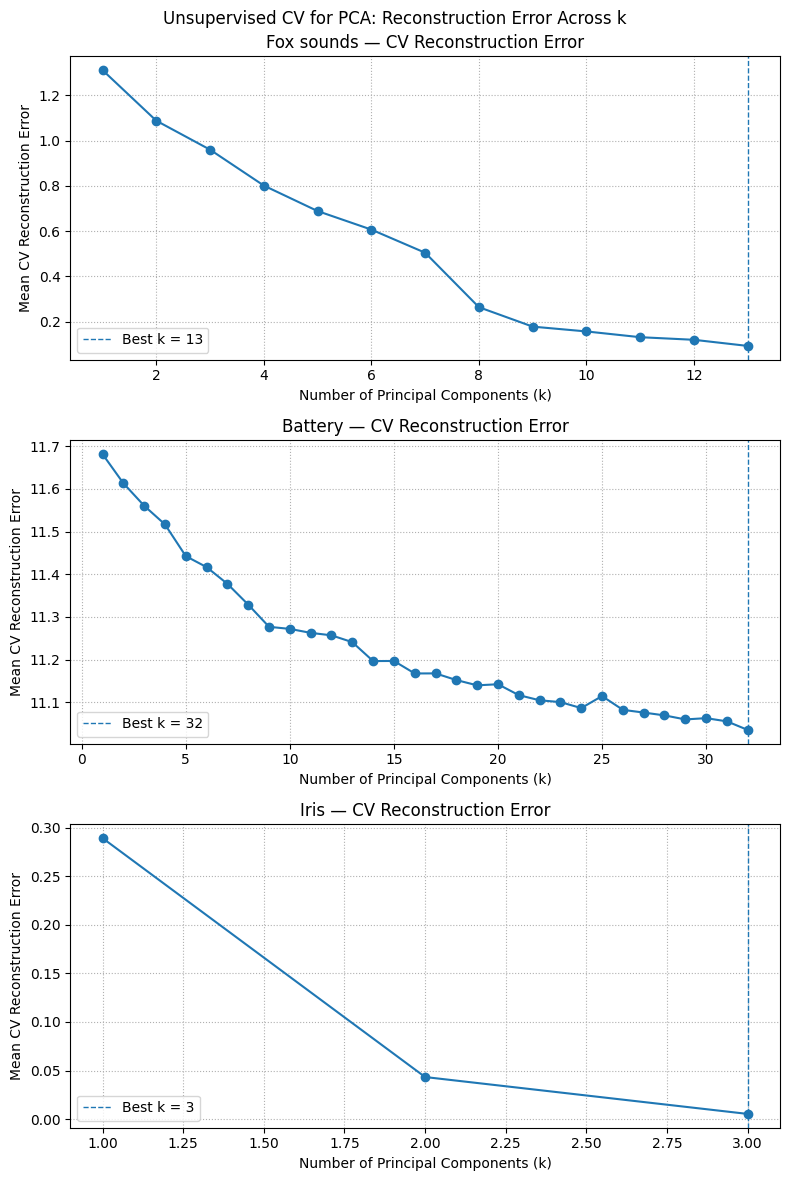

   Fox sounds | p = 27 | Best k (CV) = 13 | min MSE = 0.093032
      Battery | p = 22658 | Best k (CV) = 28 | min MSE = 11.051775
         Iris | p =  4 | Best k (CV) =  3 | min MSE = 0.005403


In [23]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.model_selection import KFold

def cv_reconstruction_errors(X, n_splits=5, random_state=42):
    """
    5-fold CV reconstruction error for each k = 1..p.
    Returns:
      ks: array of candidate k values (1..p)
      mean_errors: mean CV MSE per k
      best_k: argmin of mean_errors (1-based)
    """
    s, p = X.shape
    
    ks = np.arange(1, min(p,int(np.floor(s/n_splits))))
    mean_errors = []

    for k in ks:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        errs = []
        for train_idx, val_idx in kf.split(X):
            X_train_raw, X_val_raw = X[train_idx], X[val_idx]

            # Fit scaler on train, transform train and val (no leakage)
            scaler = StandardScaler().fit(X_train_raw)
            X_train = scaler.transform(X_train_raw)
            X_val = scaler.transform(X_val_raw)

            # Fit PCA on train (k PCs), reconstruct val, compute MSE
            pca = PCA(n_components=k, svd_solver="auto").fit(X_train)
            X_val_rec = pca.inverse_transform(pca.transform(X_val))
            mse = np.mean((X_val - X_val_rec) ** 2)
            errs.append(mse)

        mean_errors.append(np.mean(errs))

    mean_errors = np.asarray(mean_errors)
    best_k = int(np.argmin(mean_errors) + 1)
    return ks, mean_errors, best_k

# --- Load datasets ---
datasets = [
    ("Fox sounds", load_csv("data/subset_spectro-analysis_fox-labels.csv", sep=";", decimal=",", target="Annotation", drop_columns=["X", "sound.files"])[0]),
    # ("Wine", load_wine(as_frame=True).frame.drop(columns=["target"]).to_numpy()),
    ("Battery", load_csv('data/battery_data.csv', drop_columns=["EOL"])[0]),
    # ("Breast Cancer", load_breast_cancer(as_frame=True).frame.drop(columns=["target"]).to_numpy()),
    ("Iris", load_iris(as_frame=True).frame.drop(columns=["target"]).to_numpy()),
]

# --- Run CV and plot (3x1) ---
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False)

for ax, (name, X) in zip(axes, datasets):
    ks, mean_errors, best_k = cv_reconstruction_errors(X, n_splits=5, random_state=42)

    ax.plot(ks, mean_errors, marker="o", linewidth=1.5)
    ax.axvline(best_k, linestyle="--", linewidth=1.0, label=f"Best k = {best_k}")
    ax.set_xlabel("Number of Principal Components (k)")
    ax.set_ylabel("Mean CV Reconstruction Error")
    ax.set_title(f"{name} — CV Reconstruction Error")
    ax.grid(True, linestyle=":", linewidth=0.8)
    ax.legend()

fig.suptitle("Unsupervised CV for PCA: Reconstruction Error Across k", y=0.98)
fig.tight_layout()
plt.show()

# Print a compact summary
for name, X in datasets:
    _, errs, bk = cv_reconstruction_errors(X, n_splits=5, random_state=42)
    print(f"{name:>13} | p = {X.shape[1]:2d} | Best k (CV) = {bk:2d} | min MSE = {errs[bk-1]:.6f}")
